In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import nengo
import numpy as np

Let's try an impossible-to-decode function.  The input is white noise, and the output should be the value of that white noise at some point in the past.  There is no recurrence here at all, so this should fail miserably.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

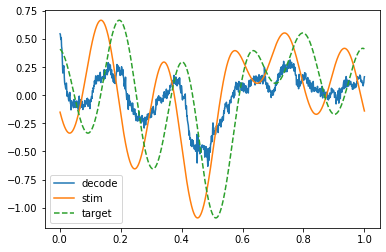

In [2]:
n_neurons = 5000
T = 1
prediction_offset = 0.06

model = nengo.Network(seed=1)
with model:
    stim = nengo.Node(nengo.processes.WhiteSignal(period=T, high=5, rms=0.5))
    ens = nengo.Ensemble(n_neurons=n_neurons, dimensions=1,
                         seed=10)
    nengo.Connection(stim, ens, synapse=None)
    
    p_stim = nengo.Probe(stim)
    p = nengo.Probe(ens.neurons)
with nengo.Simulator(model) as sim:
    sim.run(T)
    
filt = nengo.synapses.Lowpass(0.01)
dec, info = nengo.solvers.LstsqL2(reg=0.1)(filt.filt(sim.data[p]), np.roll(sim.data[p_stim], int(prediction_offset/0.001)))
plt.plot(sim.trange(), filt.filt(np.dot(sim.data[p], dec)), label='decode')
plt.plot(sim.trange(), sim.data[p_stim], label='stim')
plt.plot(sim.trange(), np.roll(sim.data[p_stim], int(prediction_offset/0.001)), ls='--', label='target')
plt.legend()
plt.show()

Okay, that's pretty horrible.  As expected.  Now, let's make things even worse by decreasing the firing rate of the neurons.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

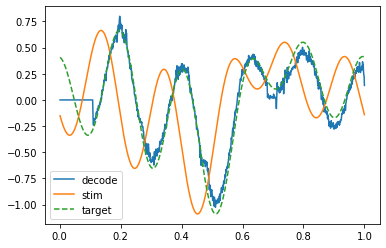

In [3]:
n_neurons = 5000
T = 1

model = nengo.Network(seed=1)
with model:
    stim = nengo.Node(nengo.processes.WhiteSignal(period=T, high=5, rms=0.5))
    ens = nengo.Ensemble(n_neurons=n_neurons, dimensions=1,
                         max_rates=nengo.dists.Uniform(5, 10),                         
                         seed=10)
    nengo.Connection(stim, ens, synapse=None)
    
    p_stim = nengo.Probe(stim)
    p = nengo.Probe(ens.neurons)
with nengo.Simulator(model) as sim:
    sim.run(T)
    
filt = nengo.synapses.Lowpass(0.01)
dec, info = nengo.solvers.LstsqL2(reg=0.1)(filt.filt(sim.data[p]), np.roll(sim.data[p_stim], int(prediction_offset/0.001)))
plt.plot(sim.trange(), filt.filt(np.dot(sim.data[p], dec)), label='decode')
plt.plot(sim.trange(), sim.data[p_stim], label='stim')
plt.plot(sim.trange(), np.roll(sim.data[p_stim], int(prediction_offset/0.001)), ls='--', label='target')
plt.legend()
plt.show()

......  What?!???   How did that suddently start working?!??

Oh, right....  it's because we're now making use of the membrane time constant to introduce some dynamics, and now we can do decodes of interesting termporal functions.   

It should also be noted that this system is operating such that a lot of the neurons are firing once per main oscilation (which is around 5Hz because yay theta waves).  I'd also expect that we'd see the standard phase precession if the input were more regular.....  :)  

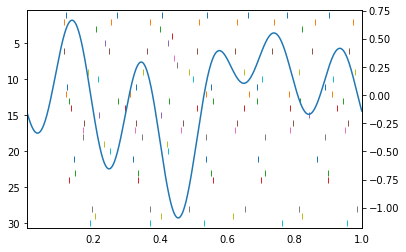

In [8]:
import nengo.utils.matplotlib
nengo.utils.matplotlib.rasterplot(sim.trange(), sim.data[p][:,:30])
plt.twinx()
plt.plot(sim.trange(), sim.data[p_stim])


It should also be noted that a lot of training data is needed to make this generalize, but it is possible....   What would be great is if there'd be some analytic solution...  Any ideas, Aaron?  :)